# EDA: Online Shopping in Retail

In this project, I will be using python to explore and analyse an industry-like dataset provided by AiCore. The project has three main sections:
1. **Downloading the dataset from AWS RDS**. This part is not including in this notebook. It is executed directly on the db_utils.py file contained in the project's repository. The table is downloaded as a .csv and stored locally. This is then uploaded as a dataframe using pandas pd.read_csv built-in function.
2. **Data cleaning and pre-processing.**
3. **Data analysis and visualisation.**


---- COMPLETE INTRO HERE AND INCLUDE DICTIONARY OF COLUMN MEANINGS

In [1]:
# Import all required packages
from data_utils import DataTransform, DataFrameInfo, Plotter, StatisticalTests
from scipy.stats import chi2_contingency, normaltest
from scipy import stats
from statsmodels.graphics.gofplots import qqplot
import missingno as msno
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

### **Initial Exploration**

First we will load the data and do some initial exploration

In [2]:
customer_activity_df = pd.read_csv('customer_activity.csv')
print(f"The shape of the DataFrame is: {customer_activity_df.shape}")
customer_activity_df.head()

The shape of the DataFrame is: (12330, 17)


,administrative,administrative_duration,informational,informational_duration,product_related,product_related_duration,bounce_rates,exit_rates,page_values,month,operating_systems,browser,region,traffic_type,visitor_type,weekend,revenue
0,0.0,0.0,0,0.0,4.0,0.0,0.2000,0.200,0.0,May,Android,Google Chrome,North America,Twitter,Returning_Visitor,False,False
1,0.0,0.0,0,0.0,26.0,876.0,0.0000,0.026,0.0,Nov,Windows,Google Chrome,Western Europe,Google search,Returning_Visitor,True,False
2,2.0,99.4,0,0.0,19.0,368.0,0.0396,0.052,0.0,Sep,Windows,Google Chrome,Asia,Twitter,Returning_Visitor,False,False
3,0.0,0.0,0,0.0,20.0,1432.0,0.0248,0.028,1.8,Dec,Windows,Google Chrome,Western Europe,Instagram ads,Returning_Visitor,False,True
4,0.0,0.0,0,0.0,33.0,694.0,0.0141,0.032,0.0,May,Android,Google Chrome,North America,Instagram ads,Returning_Visitor,False,False


In [3]:
customer_activity_df.describe()

,administrative,administrative_duration,informational,informational_duration,product_related,product_related_duration,bounce_rates,exit_rates,page_values
count,11760.000000,11418.000000,12330.000000,11994.000000,11751.000000,12129.000000,12330.000000,12330.000000,12330.000000
mean,2.308844,84.539079,0.497080,34.486687,32.814824,1192.426086,0.022381,0.042820,5.556310
std,3.364905,179.392485,1.174194,136.201557,44.597841,1767.243802,0.048847,0.048578,17.397345
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,8.000000,192.000000,0.000000,0.014000,0.000000
50%,1.000000,6.000000,0.000000,0.000000,18.000000,586.000000,0.003500,0.025000,0.000000
75%,4.000000,95.000000,0.000000,0.000000,38.000000,1425.000000,0.017600,0.049000,0.000000
max,24.000000,2155.000000,12.000000,1988.750000,485.000000,23866.000000,0.200000,0.200000,254.600000


In [4]:
info_extractor = DataFrameInfo(customer_activity_df)
print(customer_activity_df.info())
print('\n', info_extractor.generate_null_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   administrative            11760 non-null  float64
 1   administrative_duration   11418 non-null  float64
 2   informational             12330 non-null  int64  
 3   informational_duration    11994 non-null  float64
 4   product_related           11751 non-null  float64
 5   product_related_duration  12129 non-null  float64
 6   bounce_rates              12330 non-null  float64
 7   exit_rates                12330 non-null  float64
 8   page_values               12330 non-null  float64
 9   month                     12330 non-null  object 
 10  operating_systems         12319 non-null  object 
 11  browser                   12330 non-null  object 
 12  region                    12330 non-null  object 
 13  traffic_type              12330 non-null  object 
 14  visito

<Axes: >

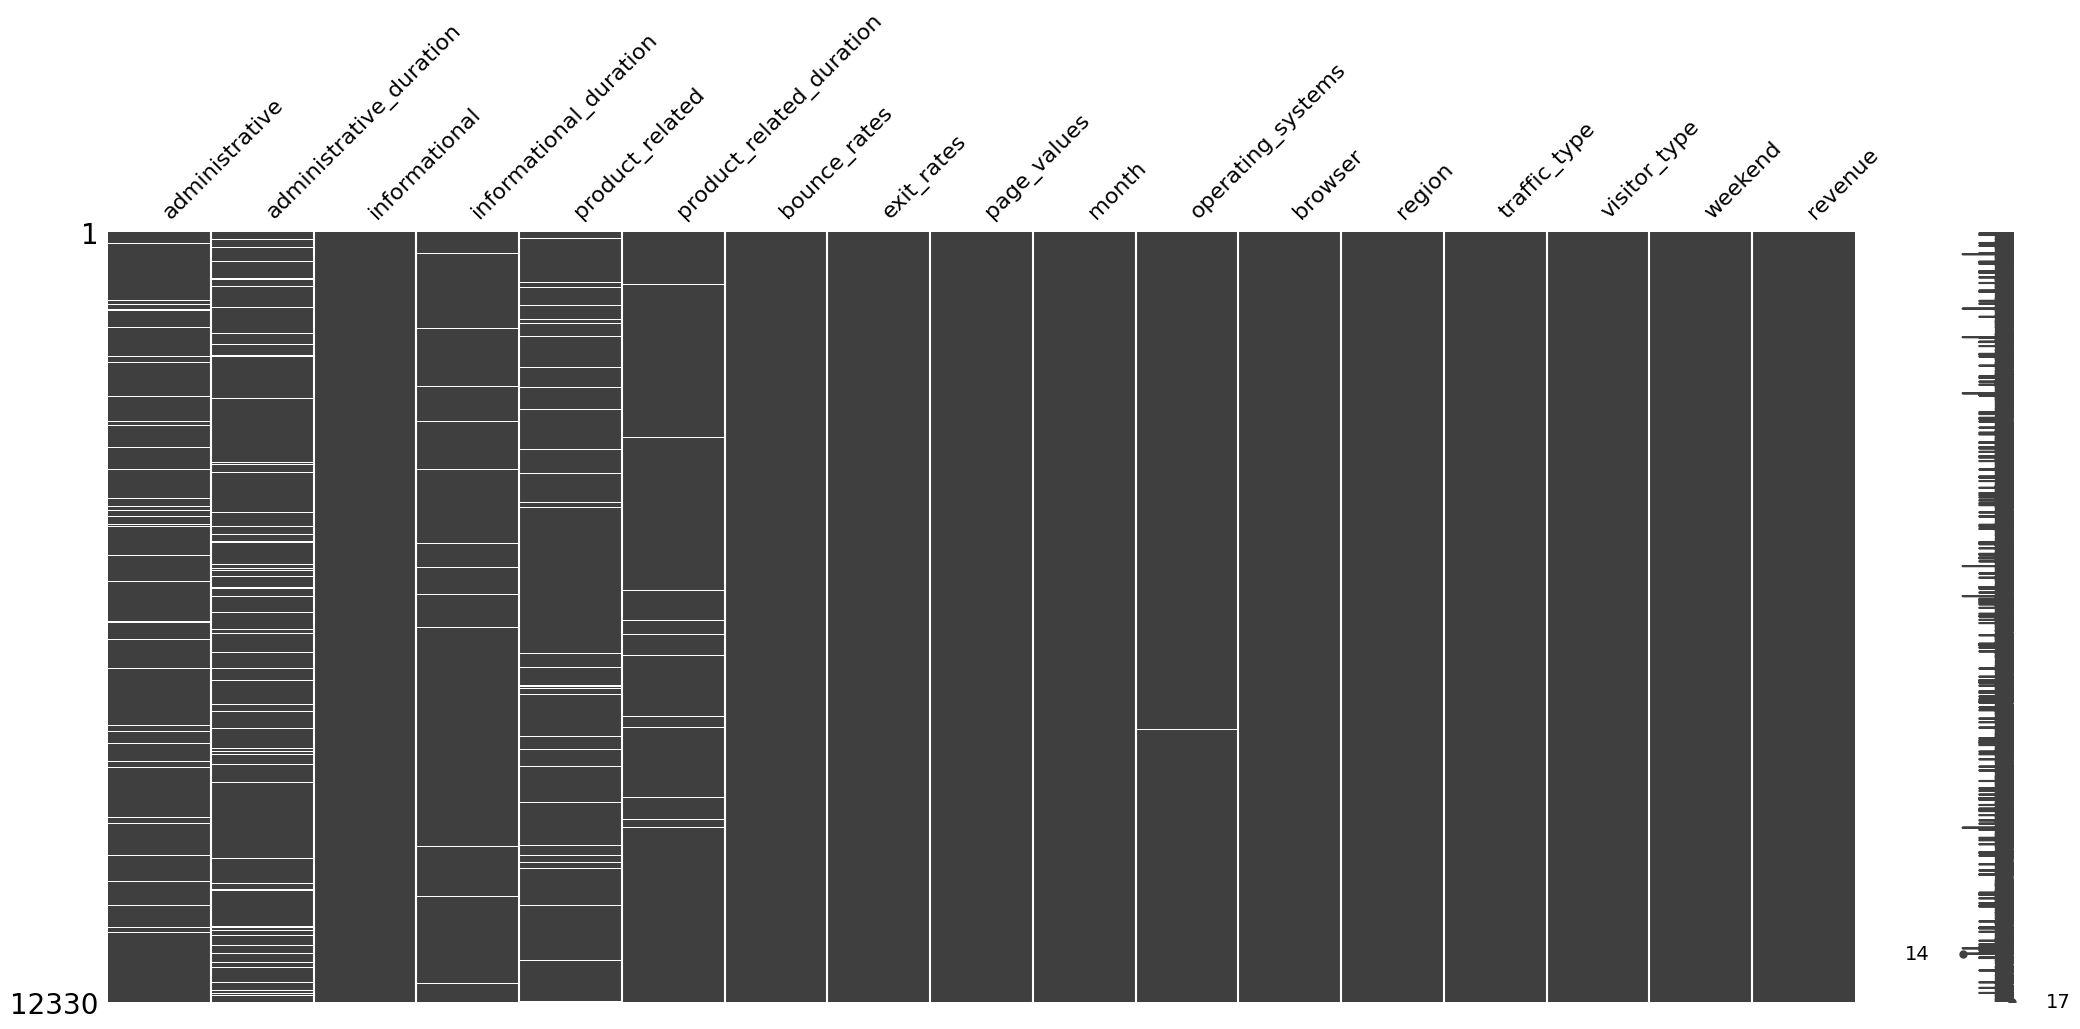

In [5]:
# Visualise missing values
nulls_plot = msno.matrix(customer_activity_df)
nulls_plot

In [6]:
info_extractor.show_distinct_values(['administrative','administrative_duration','browser','operating_systems'])
print('\n', info_extractor.count_distinct_values())
print("\nThe different regions in the dataset, and the number of records for each are: ")
print(customer_activity_df['region'].value_counts())

Unique values in administrative: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 23. 24. nan]
Unique values in administrative_duration: [0.00000000e+00 3.33333300e-02 5.00000000e-02 ... 2.13711274e+03
 2.15500000e+03            nan]
Unique values in browser: ['Android' 'Google Chrome' 'Internet Explorer' 'Microsoft Edge'
 'Mozilla Firefox' 'Opera' 'QQ' 'Safari' 'Samsung Internet'
 'Sogou Explorer' 'UC Browser' 'Undetermined' 'Yandex']
Unique values in operating_systems: ['Android' 'Windows' 'MACOS' 'ChromeOS' 'iOS' 'Ubuntu' nan 'Other']

                           distinct_values_count
column                                         
administrative                               24
administrative_duration                    3357
informational                                13
informational_duration                     1280
product_related                             296
product_related_duration                   3494
bounce_rates                 

### **Data Preprocessing**

In [7]:
transformer = DataTransform(customer_activity_df)

In [8]:
transformed_df = transformer.convert_month_to_period('month')
transformed_df = transformer.convert_columns(['weekend','revenue'],'int')
transformed_df = transformer.convert_columns(['browser','region','traffic_type','operating_systems','visitor_type'],'categorical')
transformed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype    
---  ------                    --------------  -----    
 0   administrative            11760 non-null  float64  
 1   administrative_duration   11418 non-null  float64  
 2   informational             12330 non-null  int64    
 3   informational_duration    11994 non-null  float64  
 4   product_related           11751 non-null  float64  
 5   product_related_duration  12129 non-null  float64  
 6   bounce_rates              12330 non-null  float64  
 7   exit_rates                12330 non-null  float64  
 8   page_values               12330 non-null  float64  
 9   month                     12330 non-null  period[M]
 10  operating_systems         12319 non-null  category 
 11  browser                   12330 non-null  category 
 12  region                    12330 non-null  category 
 13  traffic_type              12330

Determine which columns should be dropped

DROP ROWS HERE:
So far all missing values are: 
- OS: dropna x11 rows - DONE
- browser - undetermined only 2 - drop rows dropna? NOT YET
- admin and prod duration rows where the respective task is missing (Missing at Random)

DROP THESE COLUMNS:


### Null values in 'operating_systems' column

In [9]:
# First drop rows for missing values in the operating_systems column, they constitute < 1 % of values
cleaned_df = transformed_df.dropna(subset=["operating_systems"])

In [10]:
info_extractor = DataFrameInfo(cleaned_df)
transformer = DataTransform(cleaned_df)
stats_tests = StatisticalTests(cleaned_df)
plotter = Plotter(cleaned_df)

### Missing values in categorical columns: 'administrative' column

Categorical variable: numbers encode different administrative tasks.
Therefore, as long as it is MCAR, we should impute with the mode. 

/Users/silviaaragon/Aicore/Exploratory-data-analysis---Online-shopping-in-retail/data_utils.py:236: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  dpd.set_xticklabels(dpd.get_xticklabels(), rotation=45, ha='right')


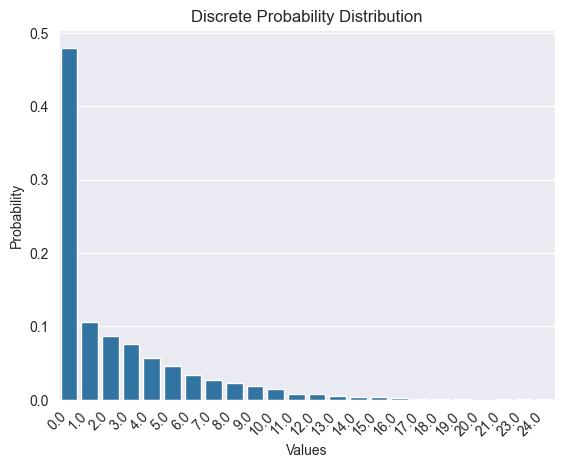

In [11]:
plotter.discrete_probability_distribution('administrative')

In [12]:
numeric_features = ['administrative_duration',
                    'informational_duration',
                    'product_related_duration',
                    'bounce_rates',
                    'exit_rates',
                    'page_values',
                    ]
categorical_features = info_extractor.extract_categorical_features(numeric_features)
stats_tests.chi_square_test("administrative", categorical_features)

Chi-square test for missing values in administrative against administrative column: 
p-value = 0.0: Significant


0.0

In [13]:
cleaned_df = transformer.impute_nulls_with_mode(["administrative"])

### Missing values in categorical columns: 'product_related'

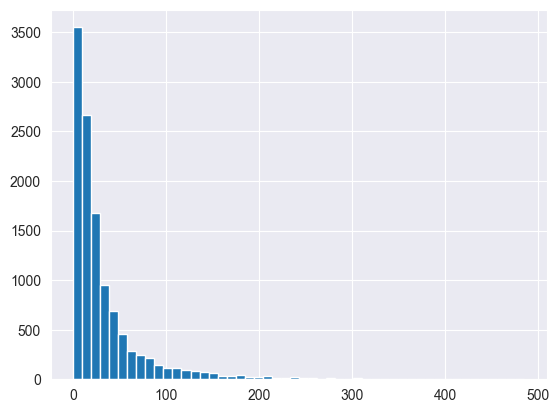

In [14]:
cleaned_df['product_related'].hist(bins = 50)
cleaned_df = transformer.impute_nulls_with_mode(["product_related"])

### Missing values in 'administrative_duration' column

Continuous variable. Potentially MCAR, or MAR if values missing depend on the missingness of values in the column 'administrative'. Let's check the correlation of both variables first, then we can perform a chi-square test

The mode of the distribution is 0.0
The mean of the distribution is 84.56652612801525
The median of the distribution is 6.0


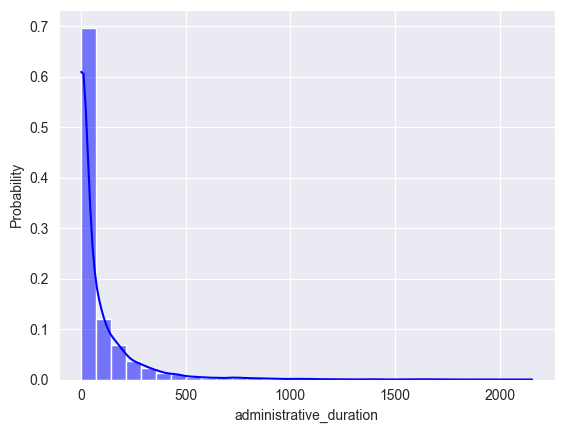

In [15]:
plotter.continuous_probability_distribution('administrative_duration')

In [16]:
cleaned_df = transformer.impute_nulls_with_median(["administrative_duration"])

### Missing values in 'informational_duration' column

The mode of the distribution is 0.0
The mean of the distribution is 34.4710697128699
The median of the distribution is 0.0


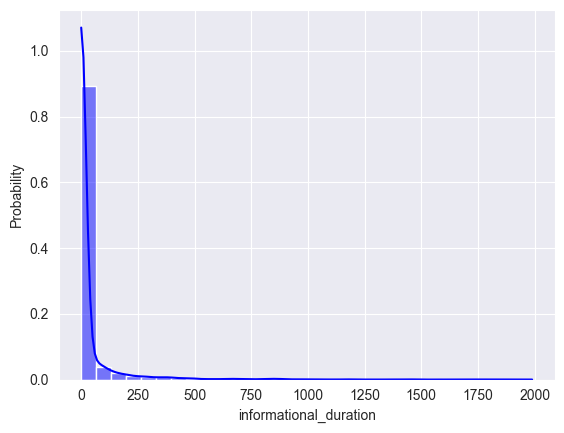

In [17]:
plotter.continuous_probability_distribution('informational_duration')

In [18]:
transformed_df = transformer.impute_nulls_with_median(['informational_duration'])

### Missing values in 'product_related_duration'

The mode of the distribution is 0.0
The mean of the distribution is 1192.547202508665
The median of the distribution is 586.0


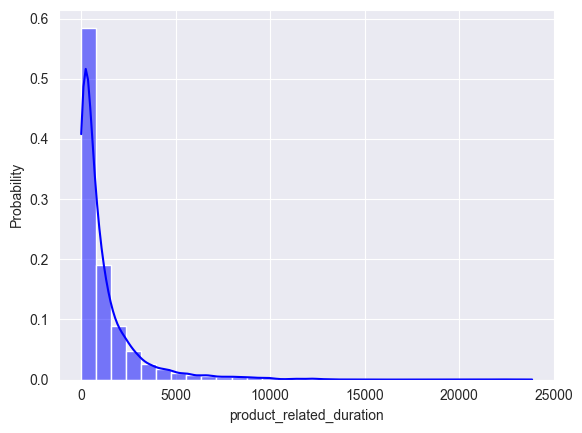

In [19]:
plotter.continuous_probability_distribution('product_related_duration')

In [20]:
cleaned_df = transformer.impute_nulls_with_median(['product_related_duration'])

Now we can check if all nulls have been dropped or imputed:

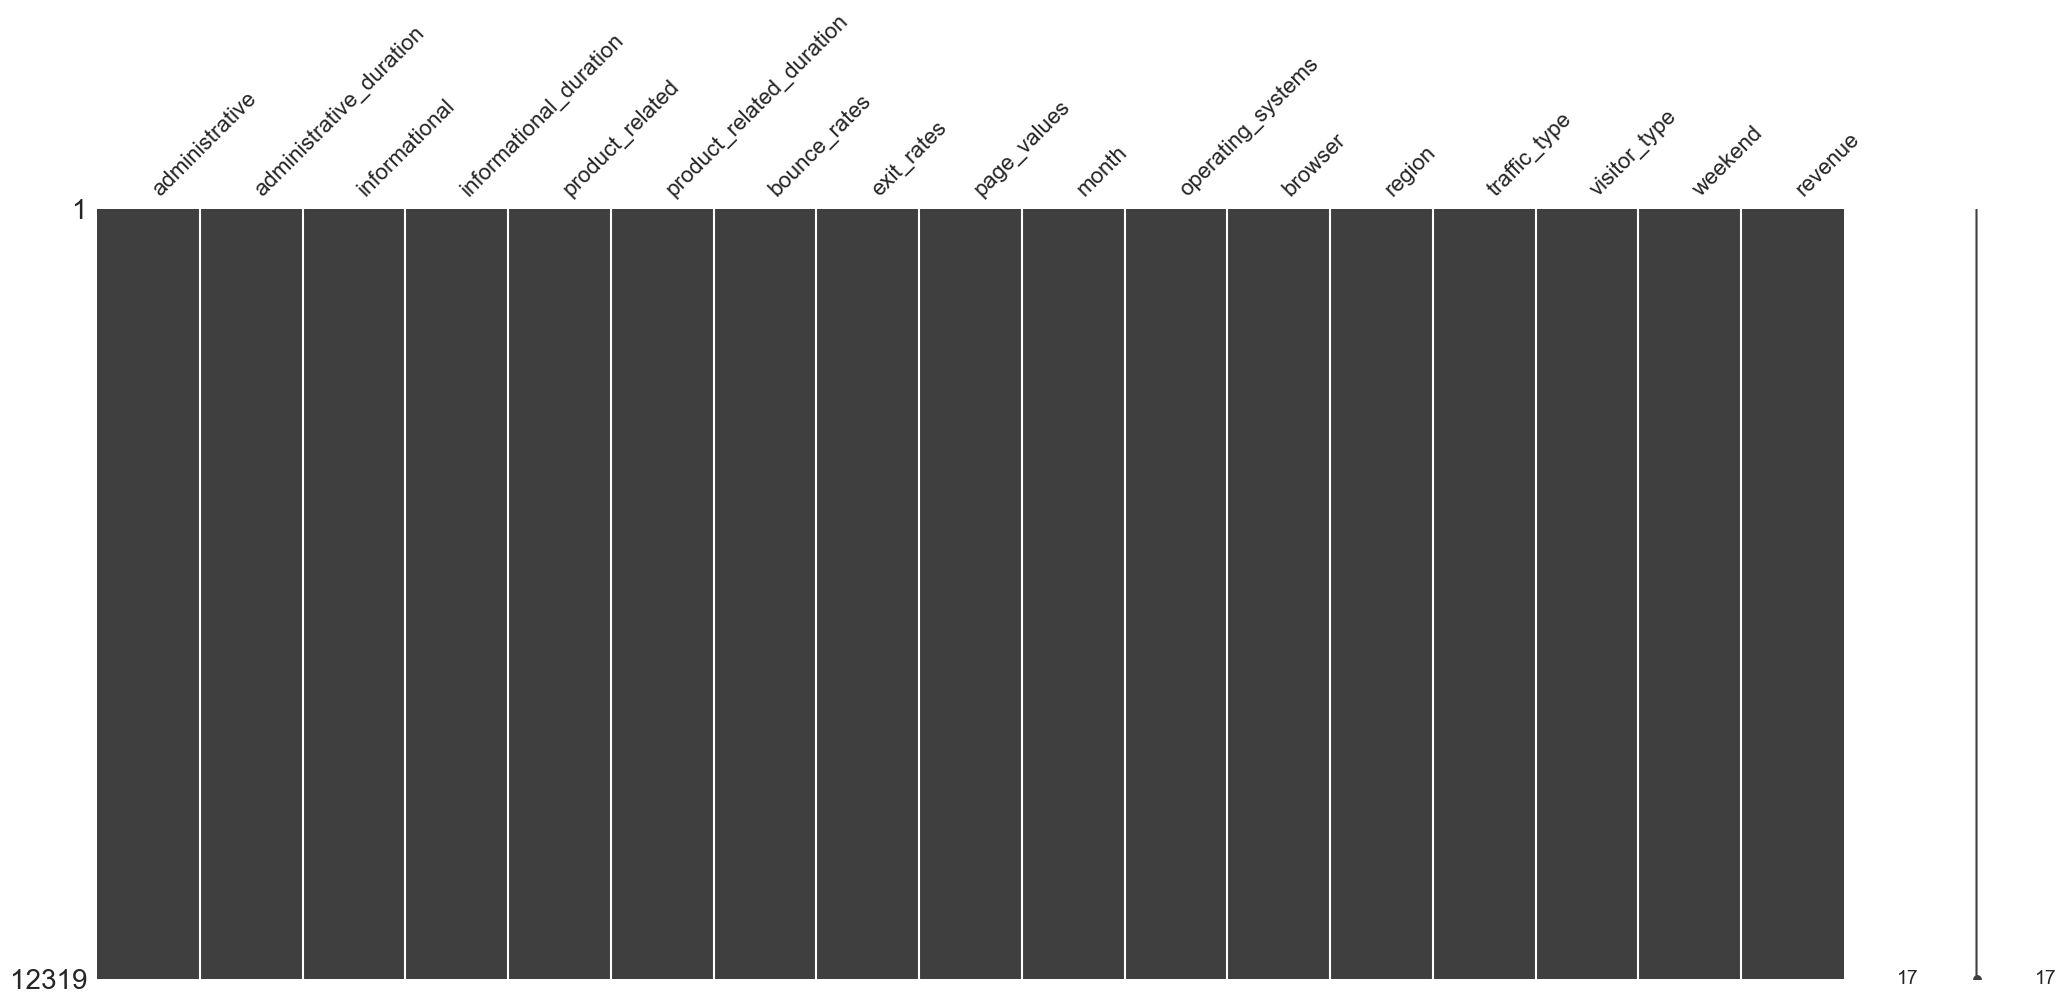

In [21]:
plotter = Plotter(cleaned_df)
plotter.nulls_dataframe_plot()

## Checking the distributions

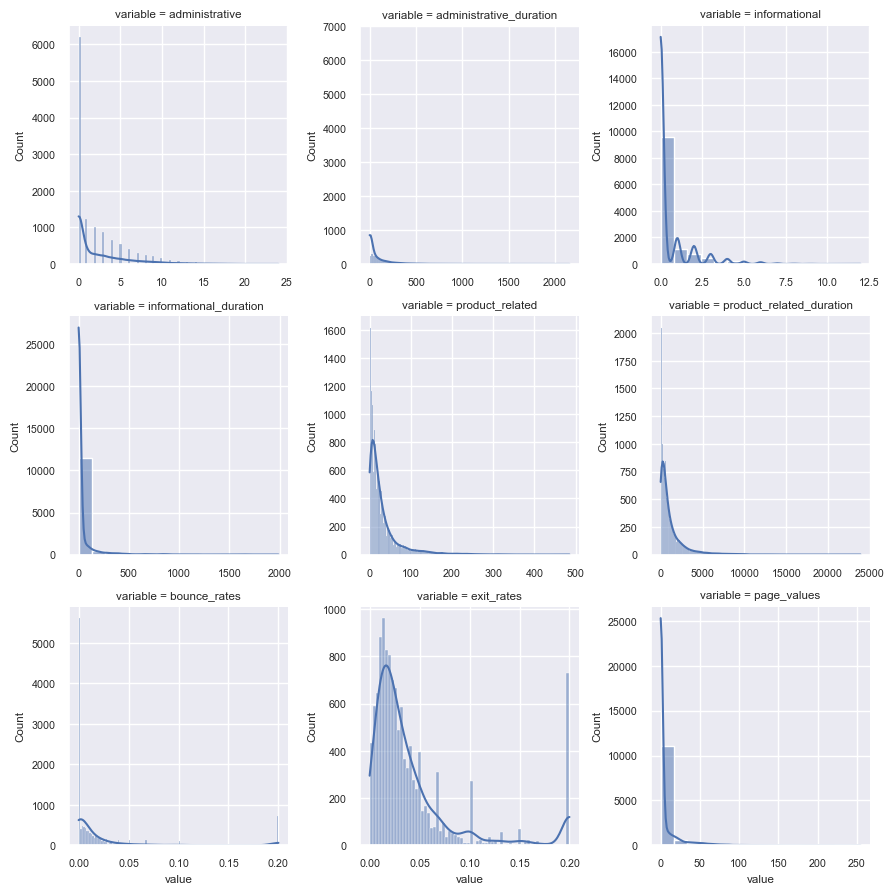

In [22]:
numeric_features = ['administrative',
                    'administrative_duration',
                    'informational',
                    'informational_duration',
                    'product_related',
                    'product_related_duration',
                    'bounce_rates',
                    'exit_rates',
                    'page_values',
                    ]

plotter.numeric_distributions_grid(numeric_features)

### Correcting skewed columns
1. **Column: 'exit_rates'**

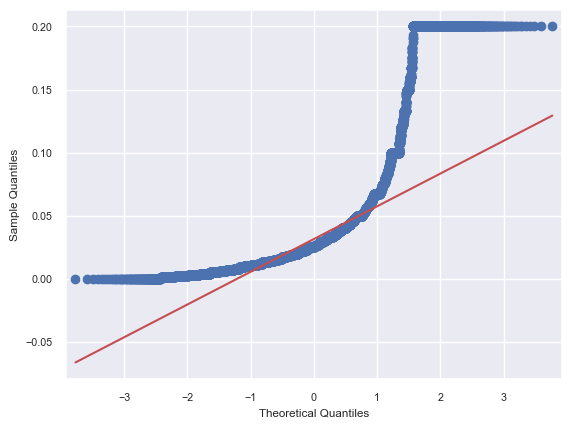

In [23]:
plotter.qqplot(['exit_rates'])

/Users/silviaaragon/Aicore/Exploratory-data-analysis---Online-shopping-in-retail/data_utils.py:305: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  t=sns.histplot(log_col,label="Skewness: %.2f"%(log_col.skew()), kde=True )


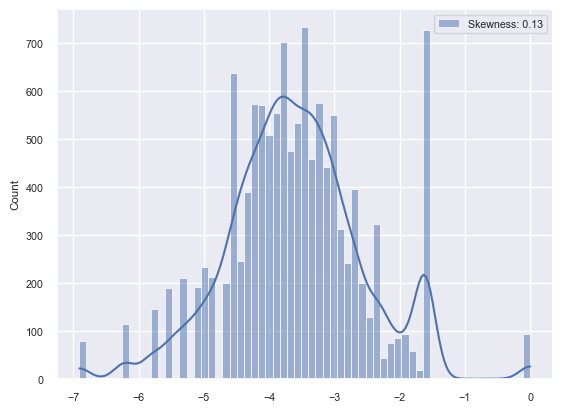

In [24]:
plotter.plot_log_transform(['exit_rates'])

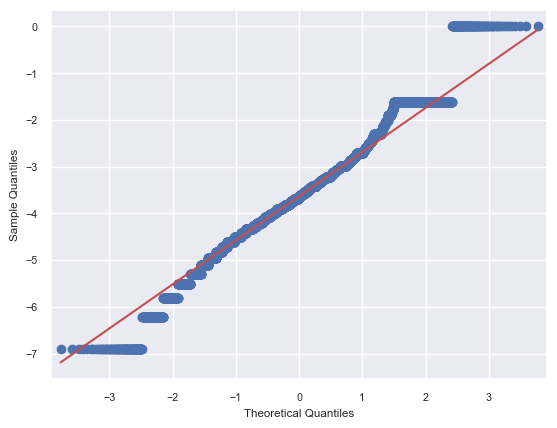

In [25]:
transformer = DataTransform(cleaned_df)
cleaned_no_skew_df = transformer.log_transform(['exit_rates'])
plotter = Plotter(cleaned_no_skew_df)
plotter.qqplot(['exit_rates'])

2. **"product_related_duration"**

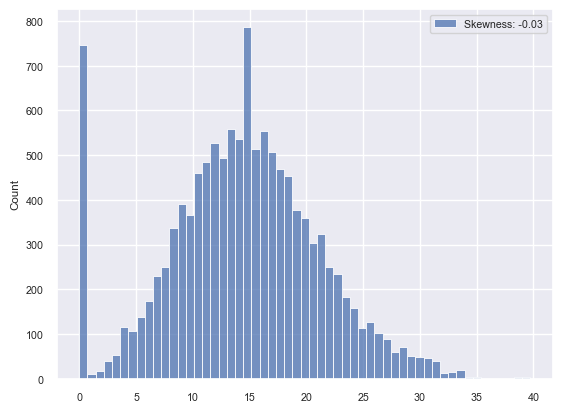

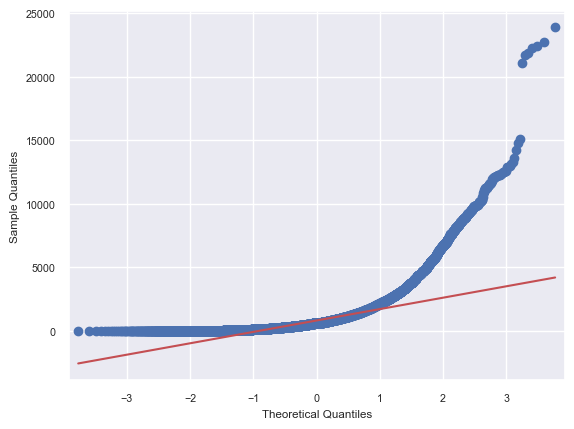

In [26]:
plotter.plot_yeo_johnson_transform('product_related_duration')
plotter.qqplot(['product_related_duration'])

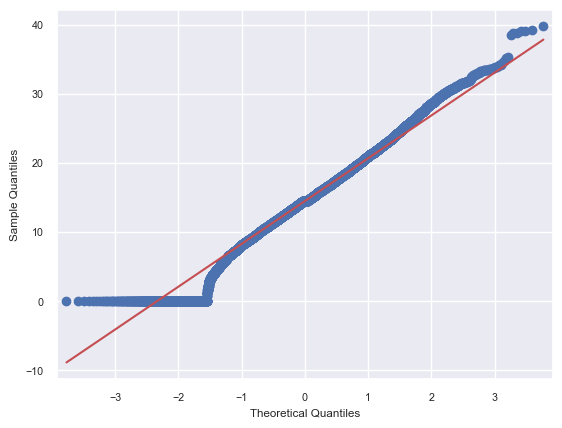

In [27]:
transformer = DataTransform(cleaned_no_skew_df)
cleaned_no_skew_df = transformer.yeo_johnson_transform(['product_related_duration'])
plotter = Plotter(cleaned_no_skew_df)
plotter.qqplot(['product_related_duration'])

## Checking the categorical distributions

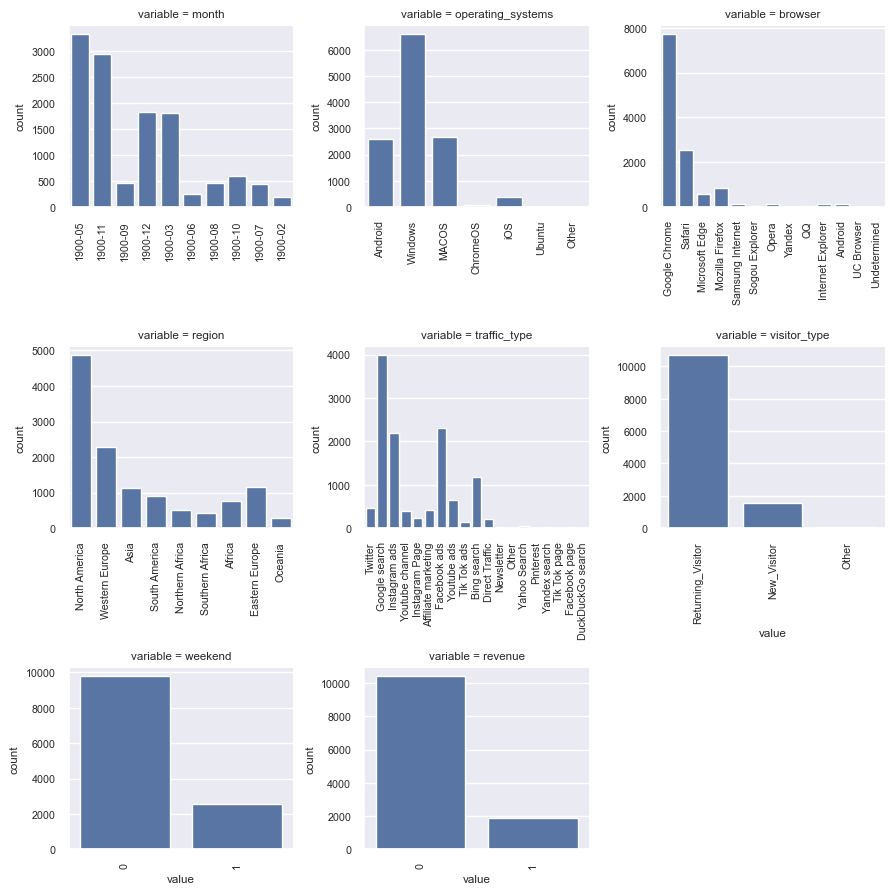

In [28]:
categorical_features = info_extractor.extract_categorical_features(numeric_features)
plotter.count_plots_grid(categorical_features)

# Correlations in the dataframe

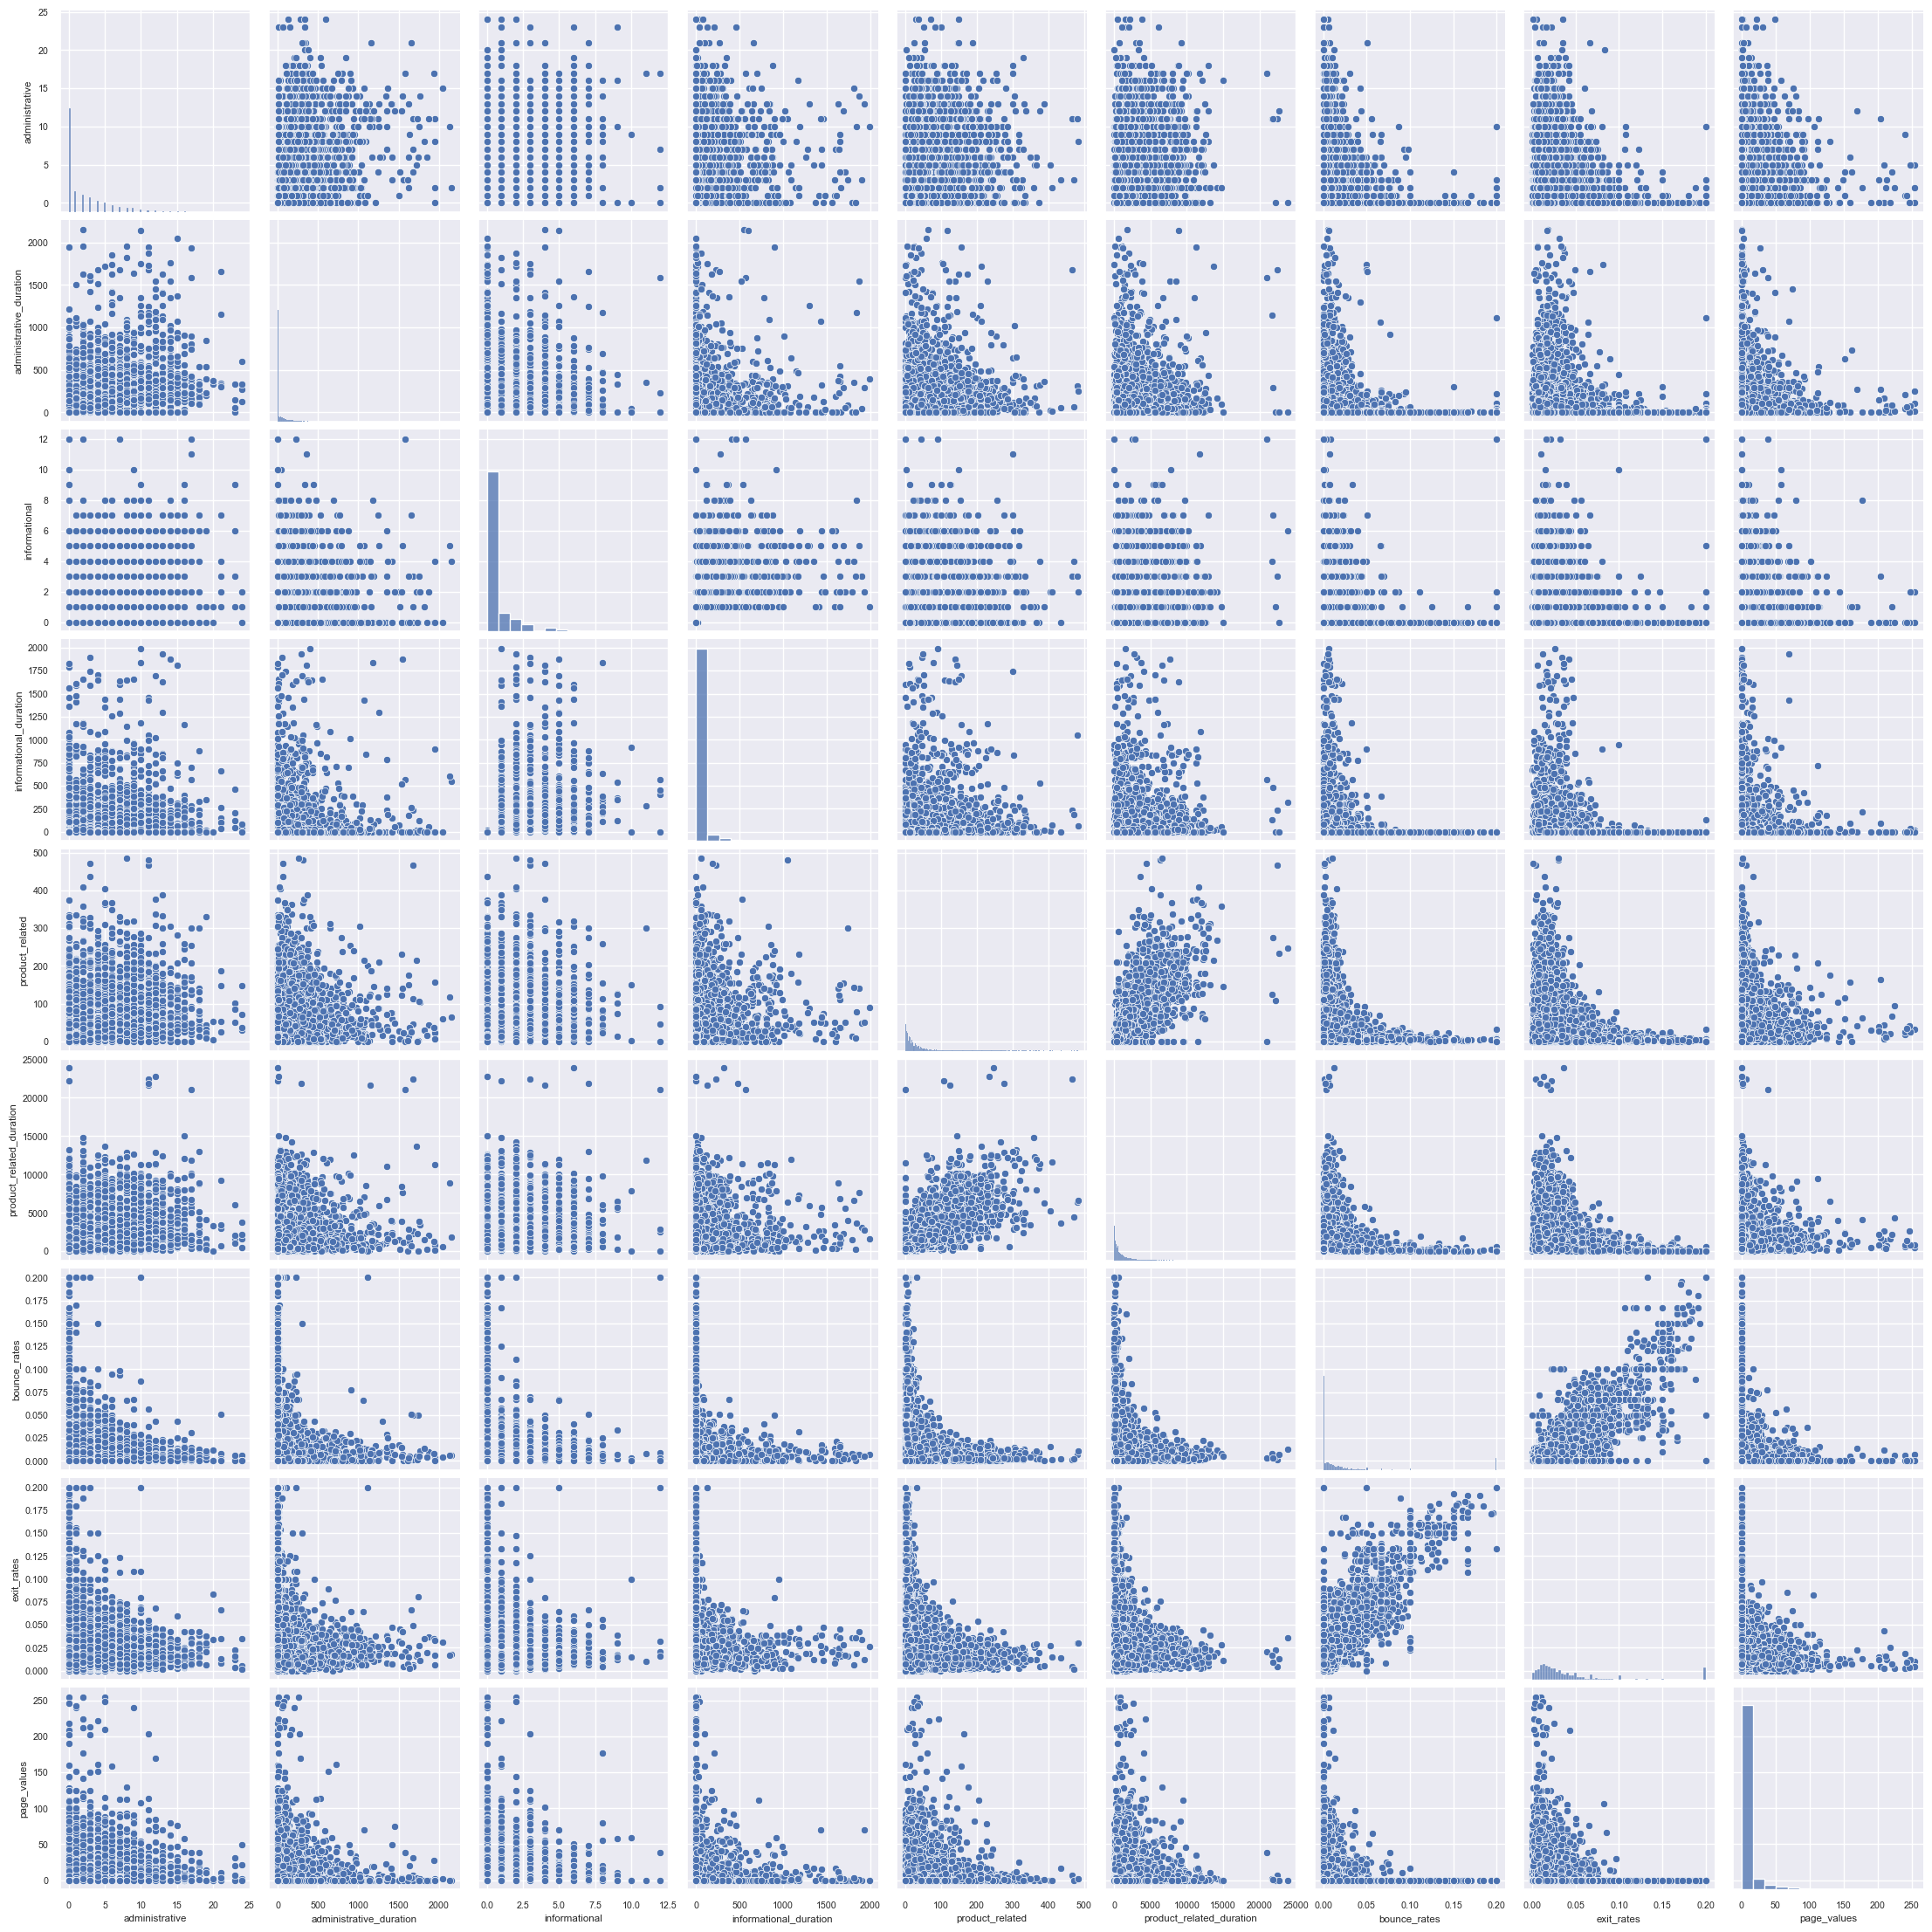

In [29]:
plotter_1 = Plotter(cleaned_df)
plotter_1.pair_correlations_grid(numeric_features)

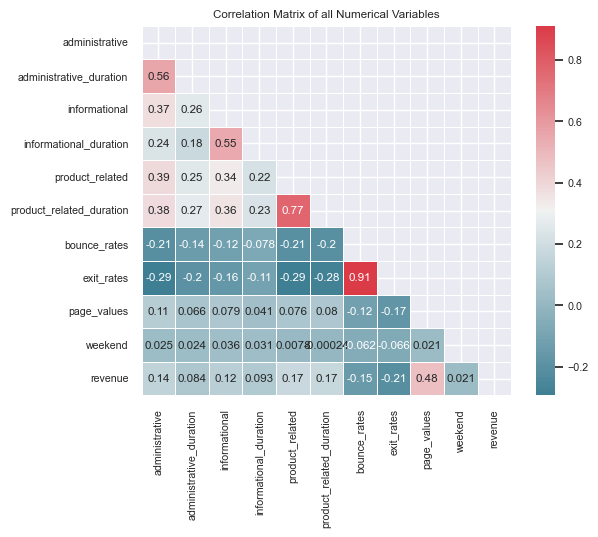

In [30]:
plotter_1.correlation_matrix_df()

DROP BOUNCE RATES COLUMN

In [31]:
column_to_drop = 'bounce_rates'
cleaned_no_skew_df.drop(column_to_drop, axis=1, inplace=True)
cleaned_no_skew_df.head()

,administrative,administrative_duration,informational,informational_duration,product_related,product_related_duration,exit_rates,page_values,month,operating_systems,browser,region,traffic_type,visitor_type,weekend,revenue
0,0.0,0.0,0,0.0,4.0,0.000000,-1.609438,0.0,1900-05,Android,Google Chrome,North America,Twitter,Returning_Visitor,0,0
1,0.0,0.0,0,0.0,26.0,16.286715,-3.649659,0.0,1900-11,Windows,Google Chrome,Western Europe,Google search,Returning_Visitor,1,0
2,2.0,99.4,0,0.0,19.0,12.565680,-2.956512,0.0,1900-09,Windows,Google Chrome,Asia,Twitter,Returning_Visitor,0,0
3,0.0,0.0,0,0.0,20.0,18.750197,-3.575551,1.8,1900-12,Windows,Google Chrome,Western Europe,Instagram ads,Returning_Visitor,0,1
4,0.0,0.0,0,0.0,33.0,15.213232,-3.442019,0.0,1900-05,Android,Google Chrome,North America,Instagram ads,Returning_Visitor,0,0
